# What

> - The darwin dataset contains handwriting data collected while the participants were performing 25 different tasks.  
> - Contains 452 columns and 175 rows  
> - The last column is the target class: P - Patient and H - Healthy   
> - 89 Patient records and 84 Healthy records 
> - For each task 18 features have been extracted, the column will be identified by the name of the features followed by a numeric identifier 
> representing the task the feature is extracted. 
> - E.g., the column with the header "total_time8" collects the values for the "total time" feature extracted from task #8. 

# Why

> This dataset was created to support the development of better solutions for diagnosing Alzheimer's disease. Since Alzheimer's affects cognitive and motor functions, handwriting analysis can reveal early signs of impairment. By studying handwriting tasks, we can identify patterns that differentiate healthy individuals from patients, potentially enabling earlier and more accurate diagnosis.

# How

> The problem: Binary Classification, but also a Risk-Sensitive Classification where a False Negative is way worse than a False Positive  
> The solution: Decision Tree Ensemble using Gradient Boosting because it can focus on getting difficult cases right by placing more emphasis on them.

# Imports

In [ ]:
import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2, VarianceThreshold, RFE, SequentialFeatureSelector
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


# Plot Config

In [167]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('default')
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Constants

In [168]:
# getting a random number for the random state
RANDOM_STATE = np.random.randint(1000)
print(f'Random State: {RANDOM_STATE}')

Random State: 903


# Data Preprocessing

In [169]:
df = pd.read_csv('../data/darwin/DARWIN.csv')
df.head()

,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Columns: 452 entries, ID to class
dtypes: float64(300), int64(150), object(2)
memory usage: 614.6+ KB


>checking for missing values, the dataset has no missing values

In [171]:
pd.set_option('display.max_rows', None)
print(df.isna().sum())

ID                       0
air_time1                0
disp_index1              0
gmrt_in_air1             0
gmrt_on_paper1           0
max_x_extension1         0
max_y_extension1         0
mean_acc_in_air1         0
mean_acc_on_paper1       0
mean_gmrt1               0
mean_jerk_in_air1        0
mean_jerk_on_paper1      0
mean_speed_in_air1       0
mean_speed_on_paper1     0
num_of_pendown1          0
paper_time1              0
pressure_mean1           0
pressure_var1            0
total_time1              0
air_time2                0
disp_index2              0
gmrt_in_air2             0
gmrt_on_paper2           0
max_x_extension2         0
max_y_extension2         0
mean_acc_in_air2         0
mean_acc_on_paper2       0
mean_gmrt2               0
mean_jerk_in_air2        0
mean_jerk_on_paper2      0
mean_speed_in_air2       0
mean_speed_on_paper2     0
num_of_pendown2          0
paper_time2              0
pressure_mean2           0
pressure_var2            0
total_time2              0
a

>using a label encoder to deal with categorical columns   

In [172]:
lb = LabelEncoder()
categorical_columns = df.select_dtypes(include = "object").columns
for col in categorical_columns:
    df[col] = lb.fit_transform(df[col])

> dropping the ID column

In [173]:
df = df.drop('ID', axis=1)

# Train Test Split

> Dividing the data into X, y to separate the features from the target  
> Also dividing into Train and Test with 80% for training and 20% for test  

> And also scalling the columns on X to avoid outliers or scale issues

In [174]:
X, y = df.drop('class', axis=1), df['class']
X_scaled = StandardScaler().set_output(transform="pandas").fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_STATE)

# Decision Tree Model

> I choose to use a Decision Tree Model first, to use a starting point to later compare with a few feature selection options    

In [175]:
model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
model_tree.fit(X_train, y_train)

y_pred = model_tree.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, pos_label=1))
print('Recall: ', recall_score(y_test, y_pred, pos_label=1))
print('F1: ', f1_score(y_test, y_pred, pos_label=1))

Accuracy:  0.7428571428571429
Precision:  0.7272727272727273
Recall:  0.8421052631578947
F1:  0.7804878048780488


> I decided to evaluate the model using cross validation since the normal train test split appeared to be overfitting 

In [176]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

scores = cross_val_score(model_tree, X, y, cv=cv, scoring='accuracy')
precision = cross_val_score(model_tree, X, y, cv=cv, scoring='precision')
recall = cross_val_score(model_tree, X, y, cv=cv, scoring='recall')
f1 = cross_val_score(model_tree, X, y, cv=cv, scoring='f1')

print('Accuracy: ', np.mean(scores))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('F1: ', np.mean(f1))

Accuracy:  0.7552287581699347
Precision:  0.7601635401635403
Recall:  0.7708333333333334
F1:  0.7603152898586336


> plotting the feature importance for the decision tree

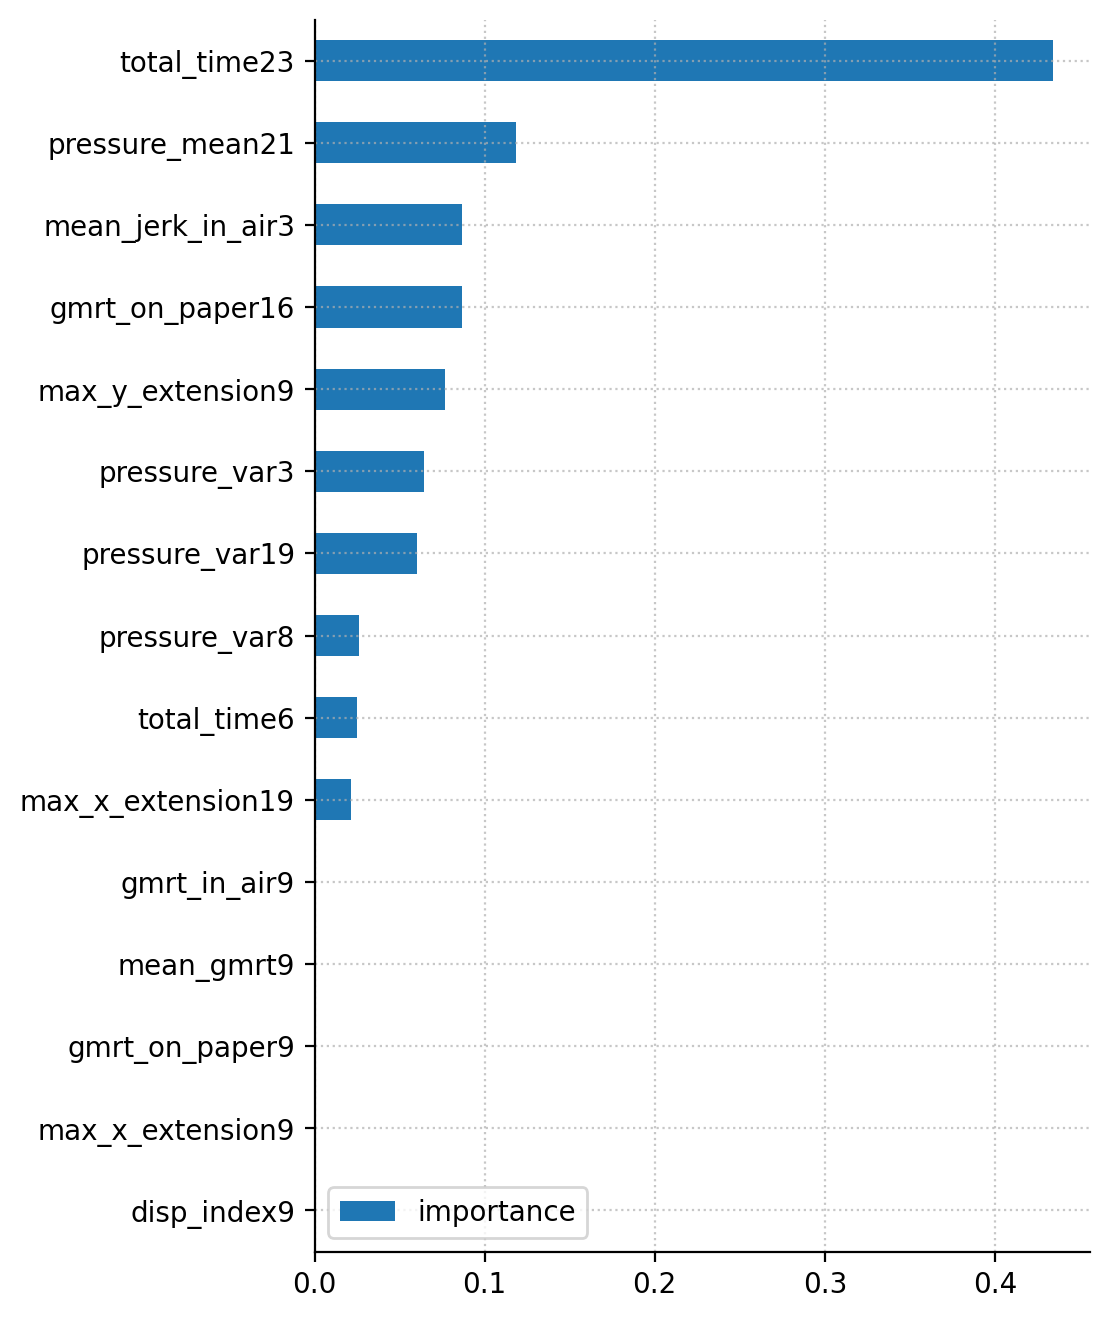

In [177]:
feature_importances = model_tree.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)[-15:]
mlp = pd.DataFrame(feature_importances[indices], index=features[indices], columns=['importance'])
mlp.sort_values(by='importance', ascending=False)
mlp.plot(kind='barh', figsize=(5, 8))
plt.show()

# Feature Selection Experiments 

> I'm going to try a few feature selection methods and compare them with the decision tree trained without any feature selction

## Filter Methods

### ANOVA

In [178]:
fs = SelectKBest(score_func=f_classif, k=2)
X_anova = fs.fit_transform(X, y)
print(X_anova)

[[390.1686194  509.7582104 ]
 [133.4771303  125.4024064 ]
 [273.9085787  320.1386921 ]
 [162.1398129  158.02652   ]
 [420.3841485  378.1094284 ]
 [250.5609577  221.0628726 ]
 [286.806431   383.8731843 ]
 [204.7597735  193.1997371 ]
 [237.1250614  221.3835371 ]
 [213.6025496  259.4888211 ]
 [208.5510882  183.1065483 ]
 [ 79.59685989 154.9173582 ]
 [463.6639004  403.185661  ]
 [151.5565383  205.4653453 ]
 [175.444654   180.0955121 ]
 [228.707377   182.181232  ]
 [355.8395023  413.8681562 ]
 [255.4432687  194.0955304 ]
 [117.9191471   91.21678348]
 [170.7108053  162.9224928 ]
 [126.6574219  189.5553653 ]
 [ 85.39058512  91.75211089]
 [121.9348171  117.937799  ]
 [171.5760377  121.6387367 ]
 [250.6249264  287.7079968 ]
 [171.5125207  188.8653558 ]
 [274.2194238  481.0383282 ]
 [329.1948082  335.3863062 ]
 [133.2129712  181.1186407 ]
 [100.0968273   88.35482914]
 [124.012273   177.1234968 ]
 [153.8502705  155.8124453 ]
 [310.3411057  347.9860164 ]
 [140.5887023  250.500057  ]
 [201.8351941 

## Wrapper Methods

### Sequential Feature Selector

In [179]:
sfs = SequentialFeatureSelector(model_tree, n_features_to_select=10)
X_sfs = sfs.fit_transform(X, y)
selected_features_sfs = X.columns[sfs.get_support()]

print("Features Selected by SFS:")
print(selected_features_sfs.tolist())

Features Selected by SFS:
['mean_acc_in_air1', 'total_time3', 'air_time4', 'max_x_extension4', 'max_y_extension4', 'mean_speed_in_air6', 'air_time13', 'pressure_var14', 'total_time15', 'mean_jerk_on_paper19']


> training a new tree with the selected features

In [180]:
X_train_sfs, X_test_sfs, y_train_sfs, y_test_sfs = train_test_split(X_sfs, y, test_size=0.2, random_state=42)

sfs_tree = DecisionTreeClassifier(random_state=42)
sfs_tree.fit(X_train_sfs, y_train_sfs)

# predict
y_pred_sfs = sfs_tree.predict(X_test_sfs)

# evaluate
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

scores = cross_val_score(sfs_tree, X_train_sfs, y_train_sfs, cv=cv, scoring='accuracy')
precision = cross_val_score(sfs_tree, X_train_sfs, y_train_sfs, cv=cv, scoring='precision')
recall = cross_val_score(sfs_tree, X_train_sfs, y_train_sfs, cv=cv, scoring='recall')
f1 = cross_val_score(sfs_tree, X_train_sfs, y_train_sfs, cv=cv, scoring='f1')

print('Accuracy: ', np.mean(scores))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('F1: ', np.mean(f1))


Accuracy:  0.7646520146520147
Precision:  0.7823809523809525
Recall:  0.7571428571428572
F1:  0.7603697936050878


### Recursive Feature Elimination

In [181]:
X_rfe = X.copy()
y_rfe = y.copy()
rfe = RFE(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE), n_features_to_select=0.15)

rfe.fit(X_rfe, y_rfe)

X_rfe = rfe.transform(X_rfe)

X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_rfe, y_rfe, test_size=0.2, random_state=RANDOM_STATE)

selected_features_rfe = X.columns[rfe.support_]

print("Features Selected by RFE:")
print(selected_features_rfe.tolist())
print(len(selected_features_rfe))


Features Selected by RFE:
['air_time3', 'disp_index3', 'gmrt_in_air3', 'gmrt_on_paper3', 'max_x_extension3', 'max_y_extension3', 'mean_acc_in_air3', 'mean_acc_on_paper3', 'mean_gmrt3', 'mean_jerk_in_air3', 'mean_jerk_on_paper3', 'mean_speed_in_air3', 'mean_speed_on_paper3', 'num_of_pendown3', 'paper_time3', 'pressure_mean3', 'pressure_var3', 'total_time3', 'air_time4', 'disp_index4', 'gmrt_in_air4', 'gmrt_on_paper4', 'max_x_extension4', 'max_y_extension4', 'mean_acc_in_air4', 'mean_acc_on_paper4', 'mean_gmrt4', 'mean_jerk_in_air4', 'mean_jerk_on_paper4', 'mean_speed_in_air4', 'mean_speed_on_paper4', 'num_of_pendown5', 'total_time8', 'num_of_pendown19', 'disp_index22', 'gmrt_in_air22', 'gmrt_on_paper22', 'max_x_extension22', 'max_y_extension22', 'mean_acc_in_air22', 'mean_acc_on_paper22', 'mean_gmrt22', 'mean_jerk_in_air22', 'mean_jerk_on_paper22', 'mean_speed_in_air22', 'mean_speed_on_paper22', 'num_of_pendown22', 'paper_time22', 'pressure_mean22', 'pressure_var22', 'total_time22', 'ai

> training a tree with the features selected 

In [182]:
model_tree_rfe = DecisionTreeClassifier(random_state=RANDOM_STATE)
model_tree_rfe.fit(X_train_rfe, y_train_rfe)

#evaluate
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

scores = cross_val_score(model_tree_rfe, X_train_rfe, y_train_rfe, cv=cv, scoring='accuracy')
precision = cross_val_score(model_tree_rfe, X_train_rfe, y_train_rfe, cv=cv, scoring='precision')
recall = cross_val_score(model_tree_rfe, X_train_rfe, y_train_rfe, cv=cv, scoring='recall')
f1 = cross_val_score(model_tree_rfe, X_train_rfe, y_train_rfe, cv=cv, scoring='f1')

print('Accuracy: ', np.mean(scores))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('F1: ', np.mean(f1))

Accuracy:  0.8109890109890109
Precision:  0.8414021164021165
Recall:  0.7761904761904762
F1:  0.7991995096406862


> getting the metrics a tree trained with rfe selected features with the number of features from 1 to 450 with a step of 10

In [ ]:
base_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

num_features_list = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

total_features = X.shape[1]

for num_features in range(1, total_features + 1, 10):
    rfe = RFE(estimator=base_model, n_features_to_select=num_features)
    X_transformed = rfe.fit_transform(X, y)

    accuracy = cross_val_score(base_model, X_transformed, y, cv=cv, scoring='accuracy')
    precision = cross_val_score(base_model, X_transformed, y, cv=cv, scoring='precision')
    recall = cross_val_score(base_model, X_transformed, y, cv=cv, scoring='recall')
    f1 = cross_val_score(base_model, X_transformed, y, cv=cv, scoring='f1')

    num_features_list.append(num_features)
    accuracies.append(mean(accuracy))
    precisions.append(mean(precision))
    recalls.append(mean(recall))
    f1_scores.append(mean(f1))




> plotting the features selected vs the metrics results

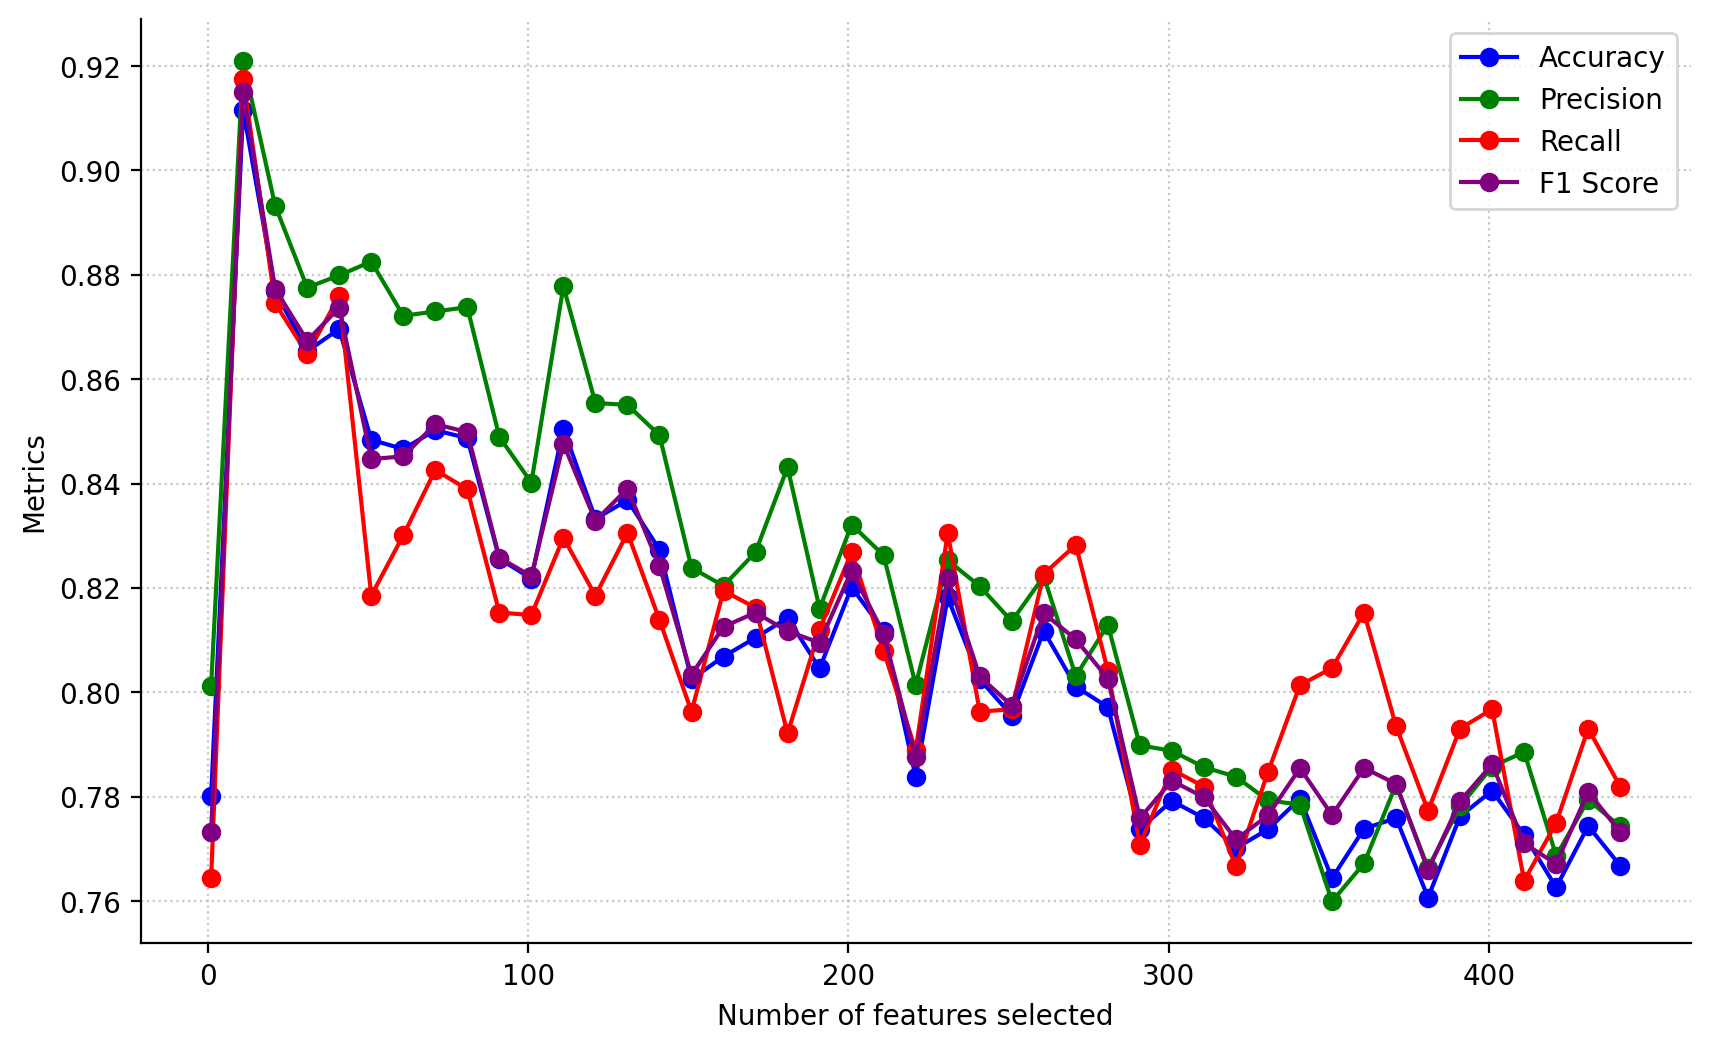

In [190]:
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, accuracies, label="Accuracy", marker='o', color='blue')
plt.plot(num_features_list, precisions, label="Precision", marker='o', color='green')
plt.plot(num_features_list, recalls, label="Recall", marker='o', color='red')
plt.plot(num_features_list, f1_scores, label="F1 Score", marker='o', color='purple')

plt.xlabel("Number of features selected")
plt.ylabel("Metrics")
plt.legend()
plt.grid(True)
plt.show()


#### Decision Tree Combined With RFE Maximizing Recall

> getting the number of features that maximizes recall

In [ ]:
max_recall = max(recalls)
max_recall_index = recalls.index(max_recall)
max_recall_num_features = num_features_list[max_recall_index]
print(f"Max Recall: {max_recall} with {max_recall_num_features} features")

> training a new tree using the rfe for feature selection with the number of fratures that maximazes reccall

In [185]:
new_model = DecisionTreeClassifier()
rfe = RFE(estimator=new_model, n_features_to_select=max_recall_num_features)
X_transformed = rfe.fit_transform(X, y)

scores = cross_val_score(new_model, X_transformed, y, cv=cv, scoring='accuracy')
precision = cross_val_score(new_model, X_transformed, y, cv=cv, scoring='precision')
recall = cross_val_score(new_model, X_transformed, y, cv=cv, scoring='recall')
f1 = cross_val_score(new_model, X_transformed, y, cv=cv, scoring='f1')

print('Accuracy: ', np.mean(scores))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('F1: ', np.mean(f1))



Accuracy:  0.8867102396514162
Precision:  0.8970202020202019
Recall:  0.8842592592592593
F1:  0.8906206693203597


# Ensemble Model - Gradient Boost


In [186]:
bst = XGBClassifier(
    n_estimators=500,        
    max_depth=5,              
    learning_rate=0.05,       
    subsample=0.8,           
    colsample_bytree=0.8,     
    scale_pos_weight=1.4,     
    min_child_weight=1,       
    gamma=3,                  
    reg_lambda=10,            
    reg_alpha=2,              
    objective='binary:logistic', 
    eval_metric='aucpr',       
)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

scores = cross_val_score(bst, X, y, cv=cv, scoring='accuracy')
precision = cross_val_score(bst, X, y, cv=cv, scoring='precision')
recall = cross_val_score(bst, X, y, cv=cv, scoring='recall')
f1 = cross_val_score(bst, X, y, cv=cv, scoring='f1')

bst.fit(X_train, y_train)

print('Accuracy: ', np.mean(scores))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('F1: ', np.mean(f1))

Accuracy:  0.8636165577342049
Precision:  0.8385202760202759
Recall:  0.9208333333333335
F1:  0.8739384371505113


> plotting the feature importance

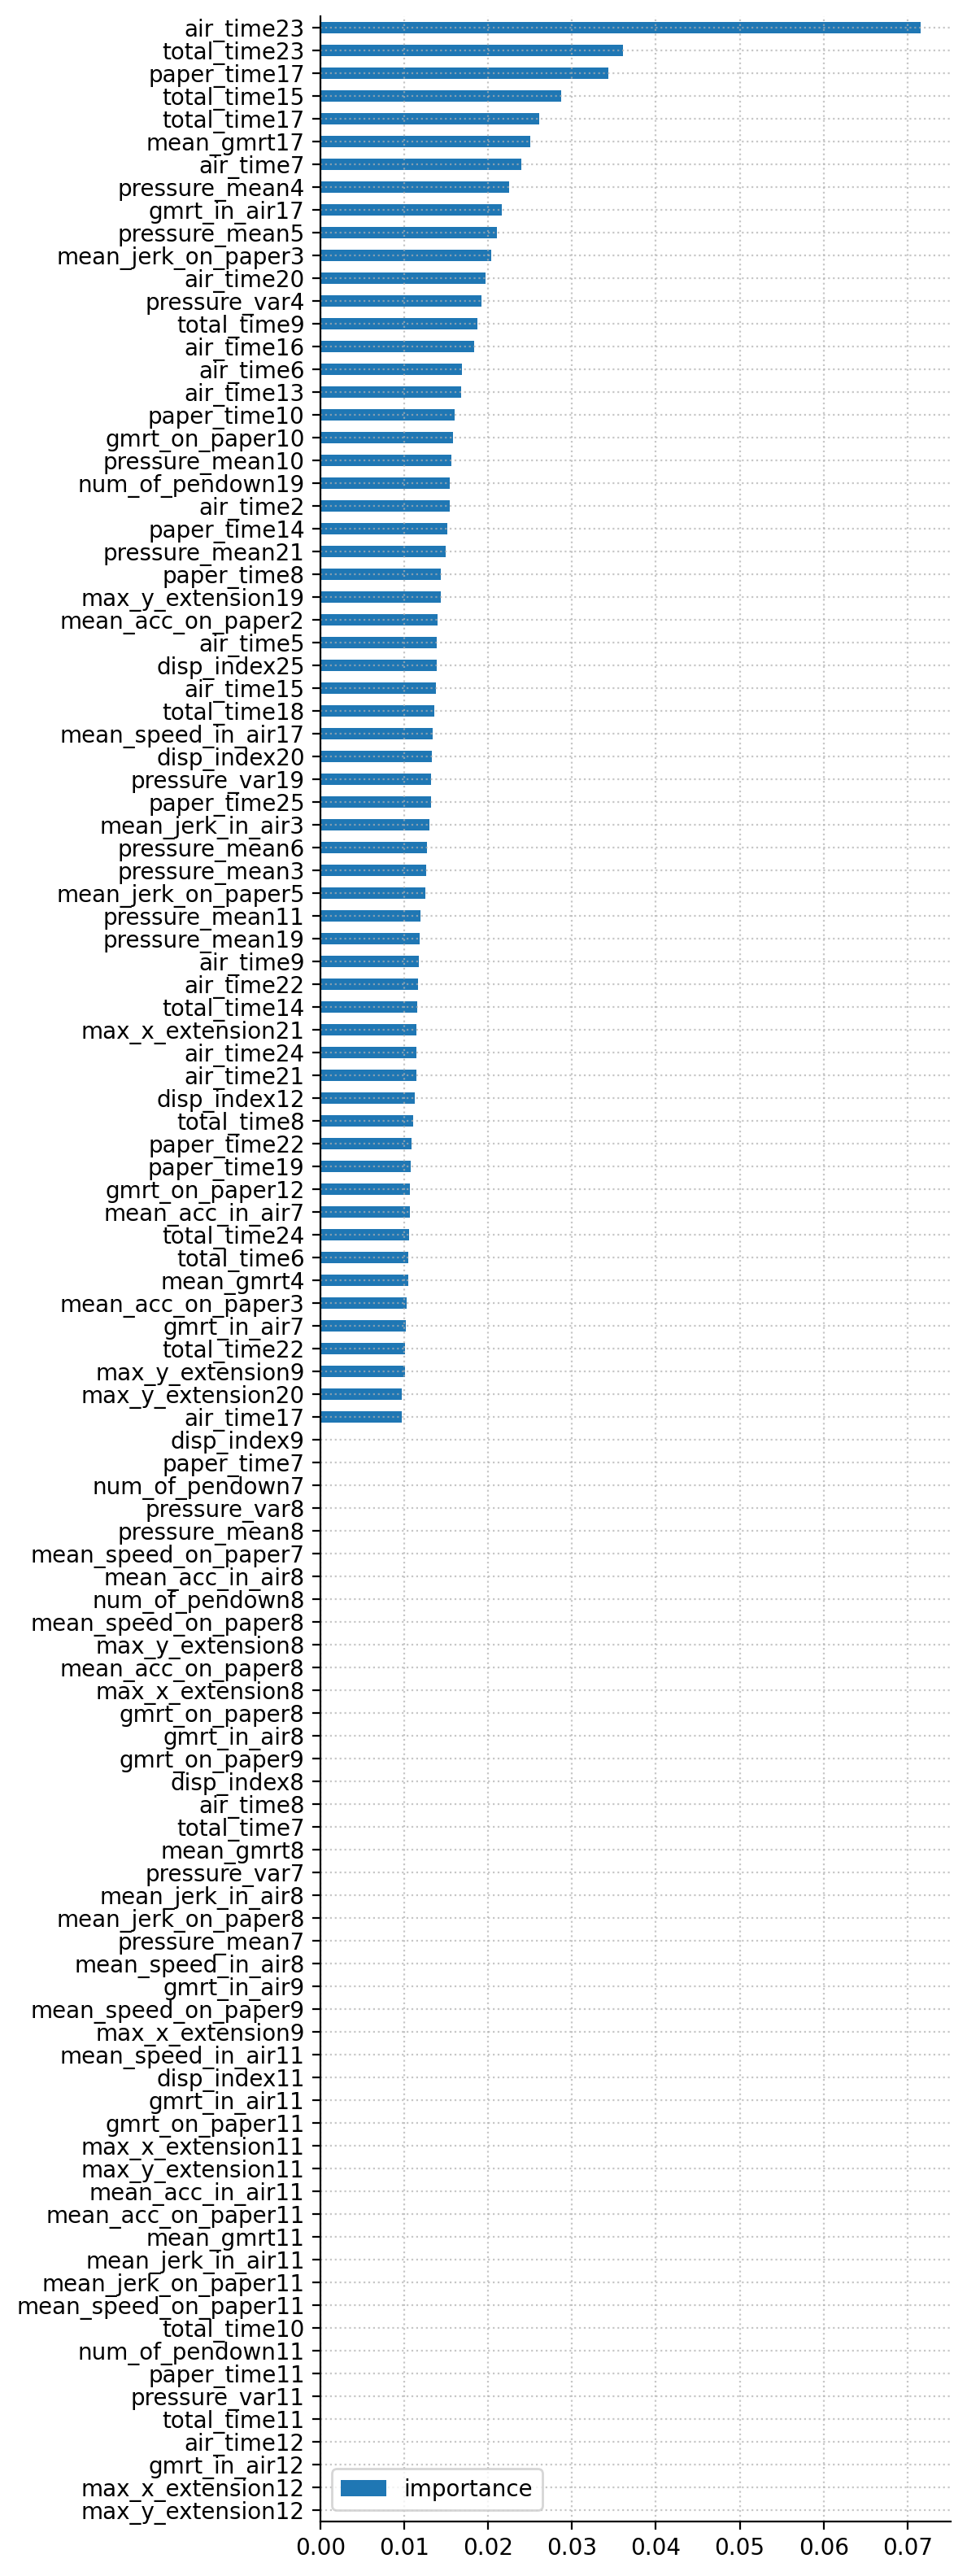

In [ ]:
feature_importances = bst.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)[-110:]
mlp = pd.DataFrame(feature_importances[indices], index=features[indices], columns=['importance'])
mlp.sort_values(by='importance', ascending=False)
mlp.plot(kind='barh', figsize=(5, 20))
plt.show()

## Training a Xgboost with the RFE Maximing Reccall features

In [188]:
bst_rfe = XGBClassifier(
    n_estimators=500,        
    max_depth=10,              
    learning_rate=0.05,       
    subsample=0.8,           
    colsample_bytree=0.8,     
    scale_pos_weight=2,     
    min_child_weight=1,       
    gamma=3,                  
    reg_lambda=10,            
    reg_alpha=2,              
    objective='binary:logistic', 
    eval_metric='aucpr',       
)

bst.fit(X_transformed, y)

scores = cross_val_score(bst, X_transformed, y, cv=cv, scoring='accuracy')
precision = cross_val_score(bst, X_transformed, y, cv=cv, scoring='precision')
recall = cross_val_score(bst, X_transformed, y, cv=cv, scoring='recall')
f1 = cross_val_score(bst, X_transformed, y, cv=cv, scoring='f1')

print('Accuracy: ', np.mean(scores))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('F1: ', np.mean(f1))

Accuracy:  0.8315904139433552
Precision:  0.8048295223295221
Recall:  0.898611111111111
F1:  0.8456377128203751


## Training A XGboost using a RFECV for feature selection

In [208]:
bst_rfecv = XGBClassifier(
    n_estimators=500,        
    max_depth=10,              
    learning_rate=0.05,       
    subsample=0.8,           
    colsample_bytree=0.8,     
    scale_pos_weight=2,     
    min_child_weight=1,       
    gamma=3,                  
    reg_lambda=10,            
    reg_alpha=2,              
    objective='binary:logistic', 
    eval_metric='aucpr',       
)

rfecv = RFECV(
    estimator=bst_rfecv,
    step=10,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=1,
    n_jobs=2,
)
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 270


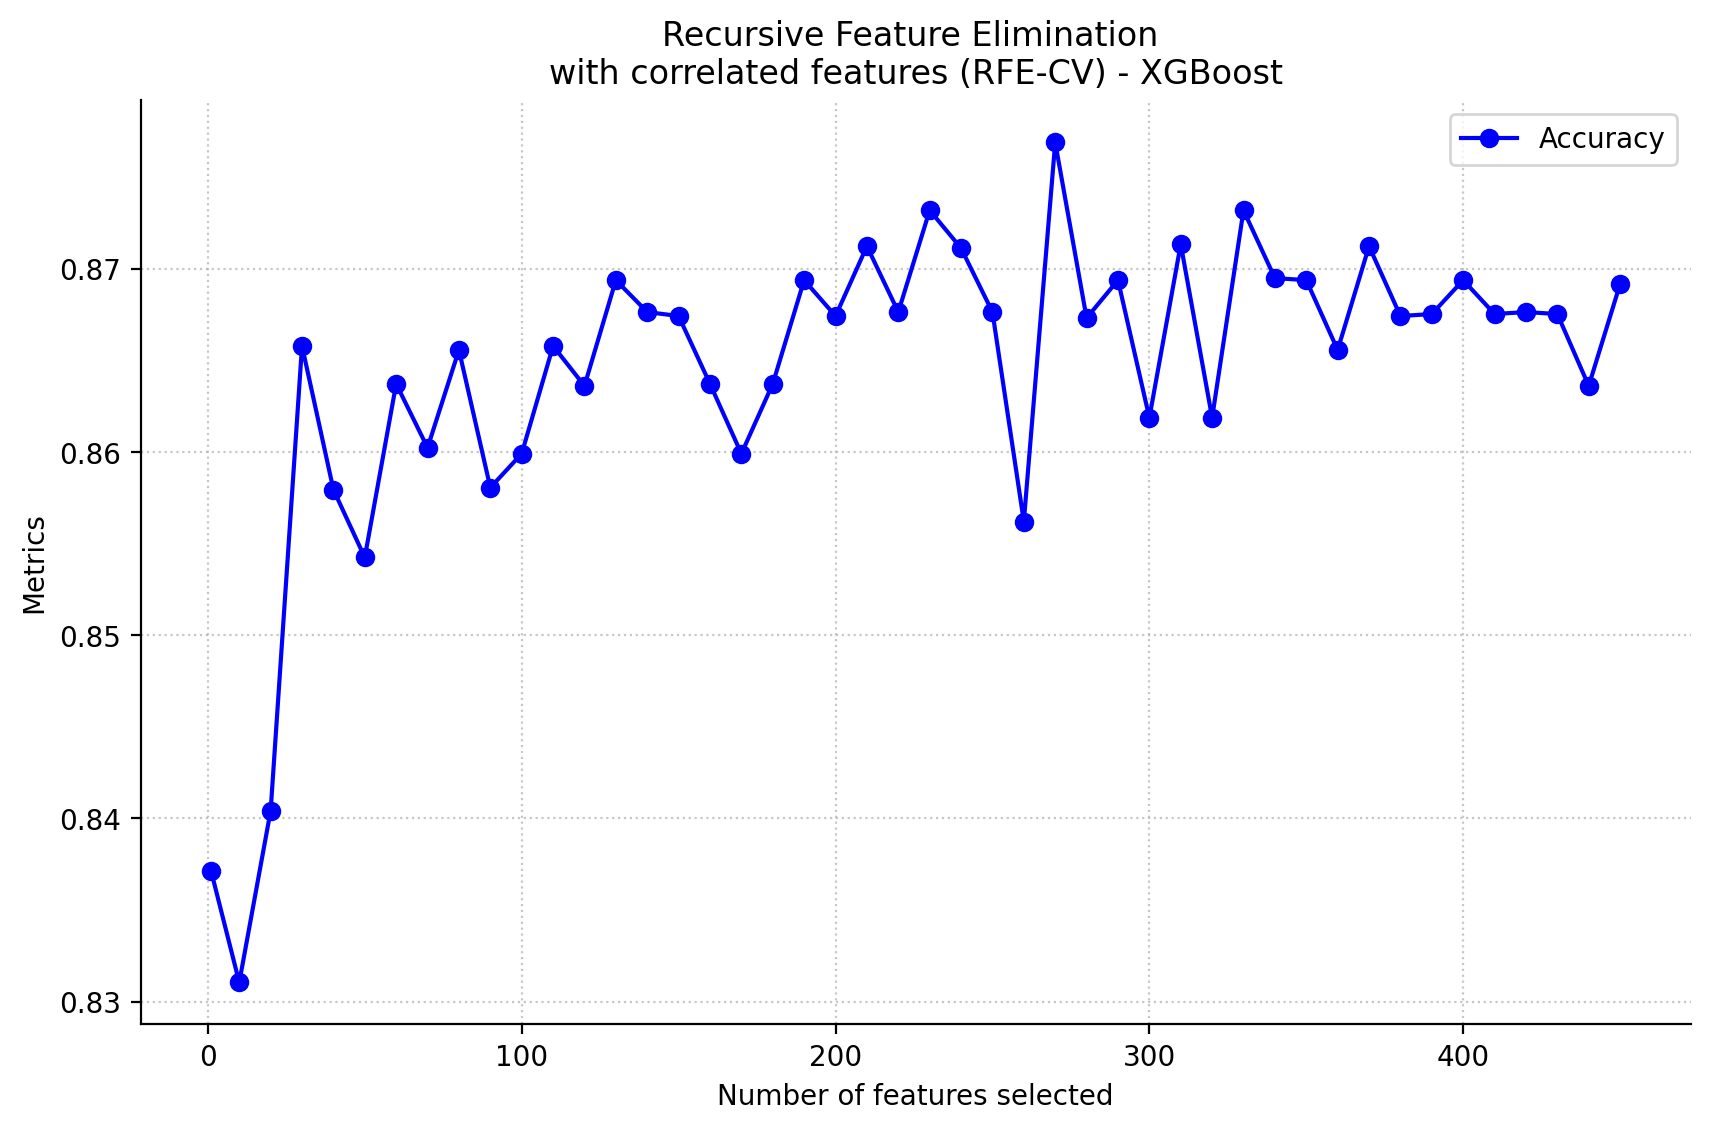

In [ ]:
cv_results = pd.DataFrame(rfecv.cv_results_)

plt.figure(figsize=(10, 6))
plt.plot(cv_results['n_features'], cv_results['mean_test_score'], label="Accuracy", marker='o', color='blue')

plt.title("Recursive Feature Elimination \nwith correlated features (RFE-CV) - XGBoost")
plt.xlabel("Number of features selected")
plt.ylabel("Metrics")
plt.legend()
plt.grid(True)
plt.show()

> with the features selected I can train the final model

In [ ]:
X_transformed = rfecv.transform(X)

bst_final = XGBClassifier(
    n_estimators=500,        
    max_depth=10,              
    learning_rate=0.05,       
    subsample=0.8,           
    colsample_bytree=0.8,     
    scale_pos_weight=2,     
    min_child_weight=1,       
    gamma=3,                  
    reg_lambda=10,            
    reg_alpha=2,              
    objective='binary:logistic', 
    eval_metric='aucpr',
)

scores = cross_val_score(bst_final, X_transformed, y, cv=cv, scoring='accuracy')
precision = cross_val_score(bst_final, X_transformed, y, cv=cv, scoring='precision')
recall = cross_val_score(bst_final, X_transformed, y, cv=cv, scoring='recall')
f1 = cross_val_score(bst_final, X_transformed, y, cv=cv, scoring='f1')

print('Accuracy: ', np.mean(scores))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('F1: ', np.mean(f1))

Accuracy:  0.8733115468409587
Precision:  0.8323057498057497
Recall:  0.9546296296296296
F1:  0.886711792106529


In [ ]:
base_model = XGBClassifier(
    n_estimators=500,        
    max_depth=10,              
    learning_rate=0.05,       
    subsample=0.8,           
    colsample_bytree=0.8,     
    scale_pos_weight=2,     
    min_child_weight=1,       
    gamma=3,                  
    reg_lambda=10,            
    reg_alpha=2,              
    objective='binary:logistic', 
    eval_metric='aucpr',
)

num_features_list = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

total_features = X.shape[1]

for num_features in range(1, total_features + 1, 10):
    # Aplicação do RFE para selecionar um subconjunto de features
    rfe = RFE(estimator=base_model, n_features_to_select=num_features)
    X_transformed = rfe.fit_transform(X, y)  # Aplica RFE nos dados

    # Cross-validation no conjunto de treino
    accuracy = cross_val_score(base_model, X_transformed, y, cv=cv, scoring='accuracy')
    precision = cross_val_score(base_model, X_transformed, y, cv=cv, scoring='precision')
    recall = cross_val_score(base_model, X_transformed, y, cv=cv, scoring='recall')
    f1 = cross_val_score(base_model, X_transformed, y, cv=cv, scoring='f1')

    # Armazena os resultados médios para cada número de features
    num_features_list.append(num_features)
    accuracies.append(mean(accuracy))
    precisions.append(mean(precision))
    recalls.append(mean(recall))
    f1_scores.append(mean(f1))

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, accuracies, label="Accuracy", marker='o', color='blue')
plt.plot(num_features_list, precisions, label="Precision", marker='o', color='green')
plt.plot(num_features_list, recalls, label="Recall", marker='o', color='red')
plt.plot(num_features_list, f1_scores, label="F1 Score", marker='o', color='purple')

plt.xlabel("Number of features selected")
plt.ylabel("Metrics")
plt.legend()
plt.grid(True)
plt.show()

# Conclusions